# Characterization of Gyroscope Noise using Allan Deviation Plots

In [1]:
import os
import numpy as np
import pandas as pd
import math

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
plt.rcParams['figure.figsize'] = (14,6)

In [3]:
def get_g_accel(lat):
    lat_rad = math.radians(lat)
    return 9.7803253359 * (1 + 0.001931853 * math.sin(lat_rad)**2) / math.sqrt(1 - e**2 * math.sin(lat_rad)**2)

In [4]:
e = 0.0818191908425

In [5]:
get_g_accel(50.5)

9.811147470598847

In [6]:
path_data = os.path.join('data/03AvData.csv' )
headers = ['time', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']

In [7]:
df = pd.read_csv(path_data, names=headers)
df.head()

,time,ax,ay,az,gx,gy,gz
0,1.676368e+09,-182,-522,16449,-128,106,-20
1,1.676368e+09,-190,-526,16472,-127,109,-21
2,1.676368e+09,-182,-538,16482,-123,108,-16
3,1.676368e+09,-186,-545,16471,-124,105,-16
4,1.676368e+09,-196,-535,16475,-122,111,-19


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755158 entries, 0 to 2755157
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    float64
 1   ax      int64  
 2   ay      int64  
 3   az      int64  
 4   gx      int64  
 5   gy      int64  
 6   gz      int64  
dtypes: float64(1), int64(6)
memory usage: 147.1 MB


In [9]:
# IMU data read through 16-bit signed A/D converter
IMU_MAX = 32767
IMU_MIN = -32768
IMU_RANGE = IMU_MAX - IMU_MIN

# Gyro reads in range +- 150 dps
GYRO_MIN = -250
GYRO_MAX = 250
GYRO_RANGE = GYRO_MAX - GYRO_MIN

# Accelorometer reads in +- 2g
ACCEL_MIN = -2
ACCEL_MAX = 2
ACCEL_RANGE = ACCEL_MAX - ACCEL_MIN

# Sensor Raw (bit) value to physical value
# val = (sensor_raw - IMU_MIN) / IMU_RANGE * sensor_range - sensor_max
for col in ['ax', 'ay', 'az']:
    df[col + '_g'] = (df[col] - IMU_MIN) / IMU_RANGE * ACCEL_RANGE + ACCEL_MIN

for col in ['gx', 'gy', 'gz']:
    df[col + '_dps'] = (df[col] - IMU_MIN) / IMU_RANGE * GYRO_RANGE + GYRO_MIN

df.head()

,time,ax,ay,az,gx,gy,gz,ax_g,ay_g,az_g,gx_dps,gy_dps,gz_dps
0,1.676368e+09,-182,-522,16449,-128,106,-20,-0.011078,-0.031830,1.004013,-0.972763,0.812543,-0.148775
1,1.676368e+09,-190,-526,16472,-127,109,-21,-0.011566,-0.032074,1.005417,-0.965133,0.835431,-0.156405
2,1.676368e+09,-182,-538,16482,-123,108,-16,-0.011078,-0.032807,1.006027,-0.934615,0.827802,-0.118257
3,1.676368e+09,-186,-545,16471,-124,105,-16,-0.011322,-0.033234,1.005356,-0.942245,0.804913,-0.118257
4,1.676368e+09,-196,-535,16475,-122,111,-19,-0.011933,-0.032624,1.005600,-0.926986,0.850690,-0.141146


Allan Varaince code from *https://mwrona.com/posts/gyro-noise-analysis/*

In [10]:
def AllanDeviation(dataArr: np.ndarray, fs: float, maxNumM: int=100):
    ts = 1.0 / fs
    N = len(dataArr)
    Mmax = 2**np.floor(np.log2(N / 2))
    M = np.logspace(np.log10(1), np.log10(Mmax), num=maxNumM)
    M = np.ceil(M)  # Round up to integer
    M = np.unique(M)  # Remove duplicates
    taus = M * ts  # Compute 'cluster durations' tau

    # Compute Allan variance
    allanVar = np.zeros(len(M))
    for i, mi in enumerate(M):
        twoMi = int(2 * mi)
        mi = int(mi)
        allanVar[i] = np.sum(
            (dataArr[twoMi:N] - (2.0 * dataArr[mi:N-mi]) + dataArr[0:N-twoMi])**2
        )
    
    allanVar /= (2.0 * taus**2) * (N - (2.0 * M))
    return (taus, np.sqrt(allanVar))  # Return deviation (dev = sqrt(var))

In [11]:
fs = 100
taugx, adgx = AllanDeviation(np.array(df['gx_dps']*1/fs).cumsum(), fs, maxNumM=1000)
taugy, adgy = AllanDeviation(np.array(df['gy_dps']*1/fs).cumsum(), fs, maxNumM=1000)
taugz, adgz = AllanDeviation(np.array(df['gz_dps']*1/fs).cumsum(), fs, maxNumM=1000)

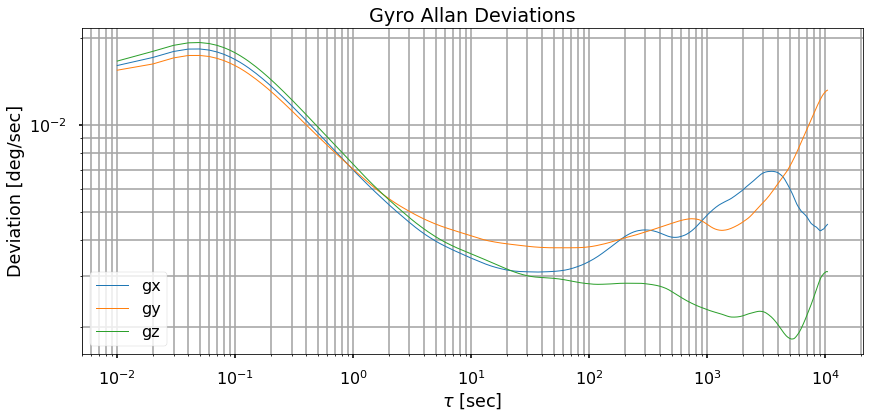

In [12]:
plt.figure()
plt.title('Gyro Allan Deviations')
plt.plot(taugx, adgx, label='gx',lineWidth=1)
plt.plot(taugy, adgy, label='gy',lineWidth=1)
plt.plot(taugz, adgz, label='gz',lineWidth=1)
plt.xlabel(r'$\tau$ [sec]')
plt.ylabel('Deviation [deg/sec]')
plt.grid(True, which="both", ls="-", color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [13]:
gyro_bias_instblt_rms = np.sqrt(np.mean([min(adgx)**2, min(adgy)**2, min(adgz)**2])) * 3600

In [14]:
print("Gyroscope Bias Instability (RMS): {} degrees/hour".format(gyro_bias_instblt_rms))

Gyroscope Bias Instability (RMS): 10.827323818739028 degrees/hour


In [15]:
tauax, adax = AllanDeviation(np.array(df['ax_g']*1/fs).cumsum(), fs, maxNumM=1000)
tauay, aday = AllanDeviation(np.array(df['ay_g']*1/fs).cumsum(), fs, maxNumM=1000)
tauaz, adaz = AllanDeviation(np.array(df['az_g']*1/fs).cumsum(), fs, maxNumM=1000)

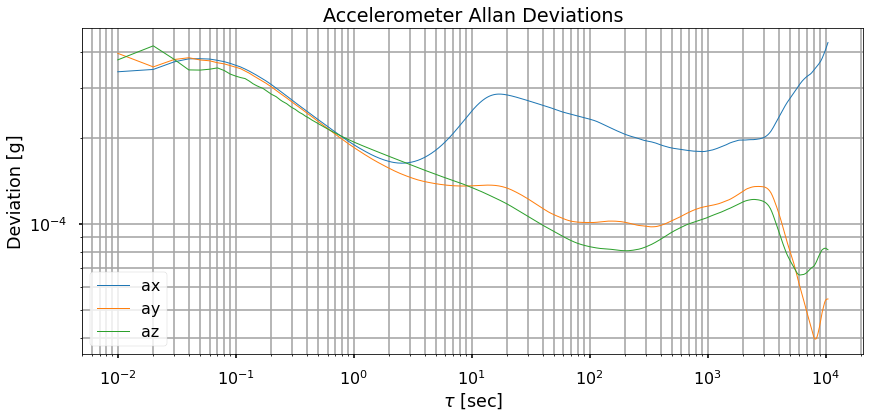

In [16]:
plt.figure()
plt.title('Accelerometer Allan Deviations')
plt.plot(tauax, adax, label='ax',lineWidth=1)
plt.plot(tauay, aday, label='ay',lineWidth=1)
plt.plot(tauaz, adaz, label='az',lineWidth=1)
plt.xlabel(r'$\tau$ [sec]')
plt.ylabel('Deviation [g]')
plt.grid(True, which="both", ls="-", color='0.65')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [19]:
accel_bias_ins_rms = np.sqrt(np.mean([min(adax)**2, min(aday)**2, min(adaz)**2])) * 10**6
print("Accelerometer Bias Instability (RMS): {} ug".format(accel_bias_ins_rms))

Accelerometer Bias Instability (RMS): 104.27197049512115 ug


In [24]:
print("Accelerometer Bias (X): {} ug".format(min(adax* 10**6))) 
print("Accelerometer Bias (Y): {} ug".format(min(aday* 10**6))) 
print("Accelerometer Bias (Y): {} ug".format(min(adaz* 10**6))) 

Accelerometer Bias (X): 163.28172676915386 ug
Accelerometer Bias (Y): 39.54130896998676 ug
Accelerometer Bias (Y): 66.28343745634855 ug
